In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import os

class ImageEnhancer:
    def __init__(self):
        pass

    def adjust_brightness_contrast(self, image, brightness=1.0, contrast=1.0):
        """Adjust brightness and contrast."""
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        enhancer_brightness = ImageEnhance.Brightness(pil_image)
        enhancer_contrast = ImageEnhance.Contrast(enhancer_brightness.enhance(brightness))
        enhanced_image = enhancer_contrast.enhance(contrast)
        return cv2.cvtColor(np.array(enhanced_image), cv2.COLOR_RGB2BGR)

    def histogram_equalization(self, image):
        """Apply histogram equalization."""
        ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
        return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)

    def apply_clahe(self, image, clip_limit=2.0, tile_grid_size=(8, 8)):
        """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)."""
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    def denoise(self, image, method='fastNlMeans', h=10):
        """Denoise the image using different methods."""
        if method == 'fastNlMeans':
            return cv2.fastNlMeansDenoisingColored(image, None, h, h, 7, 21)
        elif method == 'gaussian':
            return cv2.GaussianBlur(image, (5, 5), 0)
        elif method == 'median':
            return cv2.medianBlur(image, 5)
        else:
            raise ValueError("Unsupported denoising method")

    def sharpen(self, image):
        """Sharpen the image."""
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        return cv2.filter2D(image, -1, kernel)

    def resize_image(self, image, target_size=(640, 640)):
        """Resize image to the target size."""
        return cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)

    def normalize_image(self, image):
        """Normalize image pixel values to [0, 1]."""
        return image / 255.0

    def augment_color_jitter(self, image, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        """Apply random color jittering."""
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if brightness:
            enhancer = ImageEnhance.Brightness(pil_image)
            pil_image = enhancer.enhance(np.random.uniform(max(0, 1 - brightness), 1 + brightness))
        if contrast:
            enhancer = ImageEnhance.Contrast(pil_image)
            pil_image = enhancer.enhance(np.random.uniform(max(0, 1 - contrast), 1 + contrast))
        if saturation:
            enhancer = ImageEnhance.Color(pil_image)
            pil_image = enhancer.enhance(np.random.uniform(max(0, 1 - saturation), 1 + saturation))
        return cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    def enhance(self, image):
        """Apply a refined pipeline of enhancements."""
        # Step 1: Adjust brightness and contrast
        image = self.adjust_brightness_contrast(image, brightness=1.1, contrast=1.1)
        
        # Step 2: Apply CLAHE for localized contrast enhancement
        image = self.apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8))

        # Step 3: Denoise to remove any unwanted noise
        image = self.denoise(image, method='fastNlMeans', h=15)

        # Step 4: Sharpen the image to enhance edges
        image = self.sharpen(image)

        return image



In [ ]:
# Usage example
def process_dataset(base_folder):
    enhancer = ImageEnhancer()
    
    for split in ["train", "test", "valid"]:
        image_folder = os.path.join(base_folder, split, "images")
        label_folder = os.path.join(base_folder, split, "labels")
        enhanced_image_folder = os.path.join(base_folder, split, "enhanced_images")
        
        if not os.path.exists(enhanced_image_folder):
            os.makedirs(enhanced_image_folder)

        for filename in os.listdir(image_folder):
            if filename.endswith(".jpg"):
                input_path = os.path.join(image_folder, filename)
                output_path = os.path.join(enhanced_image_folder, filename)
                
                image = cv2.imread(input_path)
                enhanced_image = enhancer.enhance(image)
                cv2.imwrite(output_path, enhanced_image)

# Example:
process_dataset("./dataset1")


In [ ]:
from ultralytics import YOLO

# Load the YOLOv11 model (pretrained)
model = YOLO('yolo11n.pt')  # Or any pretrained YOLOv11 weights

# Train the model

model.train(
    data='D:\GC Paper\Implementation\data1.yaml',         # Path to your dataset config
    epochs=30,                # Number of epochs
    imgsz=640,                # Image size
    project='runs/train',     # Output folder for results
    name='yolov11_accident',  # Name for the run
)




In [10]:

model = YOLO('runs1/train/yolov11_accident/weights/best.pt')

results = model('./dataset2/train/non-accident/frame_000000_jpg.rf.4cbae747bc195e8a2e3600a2bcbdcf4d.jpg')
results[0].show()


image 1/1 D:\GC_Paper\Implementation\dataset2\train\non-accident\frame_000000_jpg.rf.4cbae747bc195e8a2e3600a2bcbdcf4d.jpg: 480x640 (no detections), 94.5ms
Speed: 7.0ms preprocess, 94.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


In [8]:
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from ultralytics import YOLO

# Paths to test images and labels
test_images_dir = "./dataset1/test/images"
test_labels_dir = "./dataset1/test/labels"

# Load the YOLOv8 model
model = YOLO('runs1/train/yolov11_accident/weights/best.pt')

# Initialize true and predicted labels
y_true = []
y_pred = []

# Iterate through test images
for filename in os.listdir(test_images_dir):
    if filename.endswith((".jpg", ".png")):
        # Get the ground-truth label
        label_file = os.path.join(test_labels_dir, filename.replace(".jpg", ".txt").replace(".png", ".txt"))
        with open(label_file, "r") as f:
            true_label = int(f.readline().split()[0])  # First column in YOLO format is the class ID
        y_true.append(true_label)
        
        # Predict using YOLOv8
        results = model.predict(source=os.path.join(test_images_dir, filename), conf=0.5)
        
        if len(results[0].boxes) > 0:
            # Take the predicted class of the box with the highest confidence
            predicted_label = int(results[0].boxes[0].cls[0])
        else:
            # If no box is detected, consider it a misclassification
            predicted_label = -1
        y_pred.append(predicted_label)

# Define class labels (including -1 for "no_detection")
class_labels = [-1, 0, 1, 2]
target_names = ['no_detection', 'accident', 'moderate', 'severe']

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred, labels=class_labels)
report = classification_report(y_true, y_pred, target_names=target_names)

print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)



image 1/1 D:\GC_Paper\Implementation\dataset1\test\images\1-136_jpg.rf.11b3ec6fab94a5fd2fdbe8e471a8cbec.jpg: 640x640 1 severe, 67.0ms
Speed: 3.0ms preprocess, 67.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\GC_Paper\Implementation\dataset1\test\images\1-44_jpg.rf.af423d42401851a0e3a8f3a7f0866242.jpg: 640x640 1 moderate, 77.4ms
Speed: 2.5ms preprocess, 77.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\GC_Paper\Implementation\dataset1\test\images\1-99_jpg.rf.eed5e5a84b3bf78acc5ca45c10968943.jpg: 640x640 1 moderate, 72.8ms
Speed: 2.2ms preprocess, 72.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\GC_Paper\Implementation\dataset1\test\images\1-99_jpg.rf.f031a50739f86ae7db4ab1e6a6c4f0a8.jpg: 640x640 1 moderate, 72.1ms
Speed: 4.6ms preprocess, 72.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 D:\GC_Paper\Implementation\dataset1\test\images\1003_jpeg_

C:\Users\shahr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shahr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\shahr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


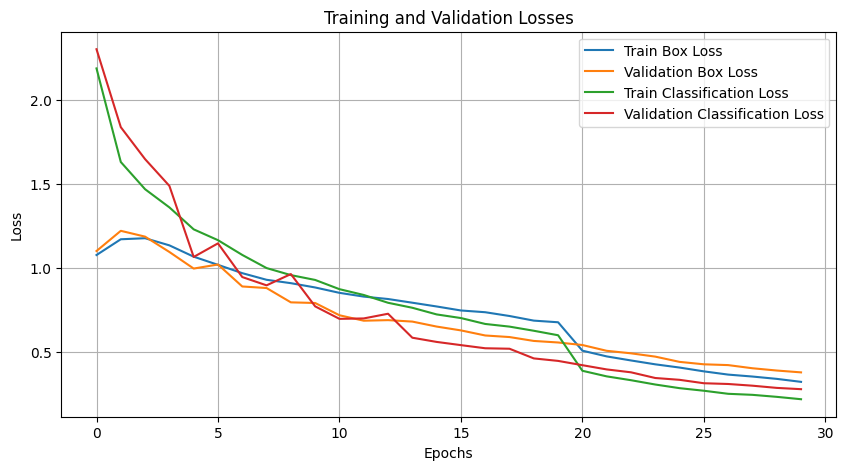

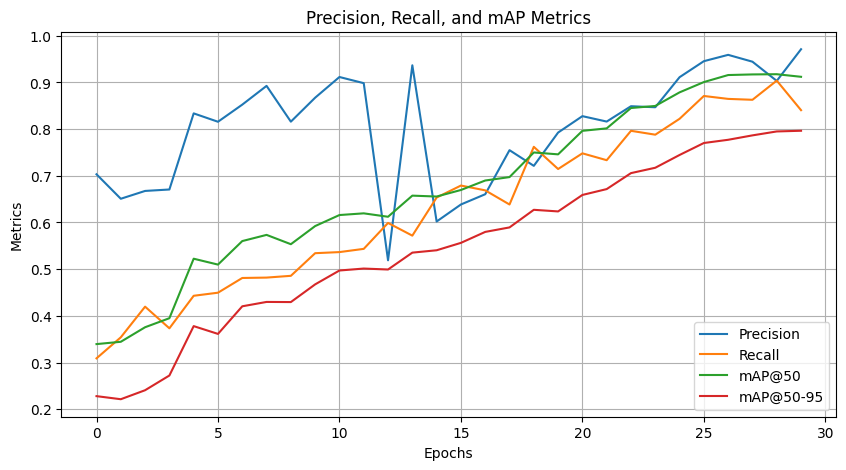

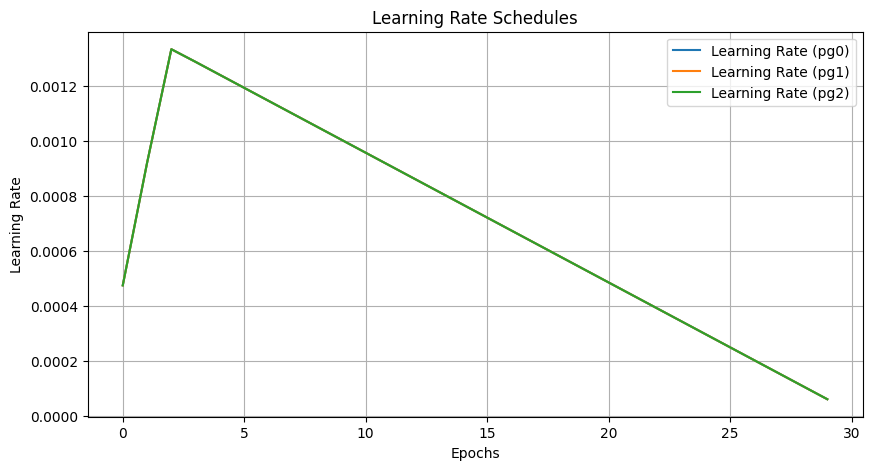

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
results = pd.read_csv('runs1/train/yolov11_accident/results.csv')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(results['train/box_loss'], label='Train Box Loss')
plt.plot(results['val/box_loss'], label='Validation Box Loss')
plt.plot(results['train/cls_loss'], label='Train Classification Loss')
plt.plot(results['val/cls_loss'], label='Validation Classification Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.grid()
plt.show()

# Plot precision, recall, and mAP
plt.figure(figsize=(10, 5))
plt.plot(results['metrics/precision(B)'], label='Precision')
plt.plot(results['metrics/recall(B)'], label='Recall')
plt.plot(results['metrics/mAP50(B)'], label='mAP@50')
plt.plot(results['metrics/mAP50-95(B)'], label='mAP@50-95')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Precision, Recall, and mAP Metrics')
plt.grid()
plt.show()

# Plot learning rates
plt.figure(figsize=(10, 5))
plt.plot(results['lr/pg0'], label='Learning Rate (pg0)')
plt.plot(results['lr/pg1'], label='Learning Rate (pg1)')
plt.plot(results['lr/pg2'], label='Learning Rate (pg2)')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedules')
plt.grid()
plt.show()


In [3]:
import pandas as pd

# Load the CSV file
results = pd.read_csv('runs1/train/yolov11_accident/results.csv')

# Print the first few rows to check column names
print(results.head())

# Print the column names
print(results.columns)

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   2441.17         1.07605         2.18897         1.39588   
1      2   4601.68         1.17002         1.63083         1.45146   
2      3   6715.94         1.17622         1.46846         1.46173   
3      4   8837.34         1.13368         1.36017         1.42753   
4      5  10952.90         1.06620         1.22922         1.38269   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.70330            0.30892           0.33945   
1               0.65086            0.35396           0.34440   
2               0.66762            0.41966           0.37558   
3               0.67071            0.37329           0.39493   
4               0.83379            0.44298           0.52240   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.22793       1.09992       2.30341       1.52048  0.000475   
1              0.22134       1.22038  